## Deep QNetworks

Deep Qlearning with experience replay.

things to do:
- add pickle of few metrics
- try to speed up
- adding visualizing the policy


In [9]:
import sys
sys.path.insert(0, '/home/alexserra98/uni/r_l/project/Deep-QNetworks/')

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import copy
from src_code.qnetworks import ReplayBuffer
from src_code.buffers import SeqReplayBuffer
from src_code.deep_qnetworks import DQN , SnakeEnv, SnakeAgent
from tqdm import tqdm
import gymnasium as gym
from gymnasium import spaces
import pickle
from src_code.train import train_step

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
batch_size = 32  # Size of batch taken from replay buffer

## Set up

In [12]:
NUM_ENVS = 1
# initialize the environment 
Lx = 10
Ly = 10

env = SnakeEnv(size =(Lx,Ly))


# Initialize the models
model = DQN(in_channels =1, num_actions=env.action_space.n, input_size=env.Lx)
# The target model makes the prediction of future rewards.
# The weights of a target model get updated every 10000 steps thus when the
# loss between the Q-values is calculated the target Q-value is stable.
model_target = DQN(in_channels = 1, num_actions=env.action_space.n, input_size=env.Lx)

model.to(device)
model_target.to(device)

# In the Deepmind paper they use RMSProp however then Adam optimizer
# improves training time
optimizer = torch.optim.Adam(model.parameters(), lr=0.00025)
# huber loss
loss_function = nn.HuberLoss()

# Train hyperparameters

cur_frame = 0
last_100_ep_rewards = []
max_steps_per_episode = 200
max_num_episodes = 10000
deque_size = 100
env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=deque_size)

# Train the model after 4 actions
update_after_actions = 4
# How often to update the target network
update_target_network = 10

# Number of frames to take random action and observe output
epsilon_random_frames = 50000
# Number of frames for exploration
epsilon_greedy_frames = 100000.0

filename = 'dqn_results.txt'

# Initialize the agent
num_actions = env.action_space.n
#action_space = spaces.Discrete(4)
learning_rate = 0.01
initial_epsilon = 1.0

final_epsilon = 0.1
epsilon_decay = (initial_epsilon - final_epsilon) / epsilon_greedy_frames #(max_num_episodes / 2) 
snake_agent = SnakeAgent(learning_rate, initial_epsilon, epsilon_decay, final_epsilon, num_actions,  env, (Lx,Ly), 0.95, NUM_ENVS)

## Train

In [13]:
replay = {}

In [14]:
# initialize the buffer, with a size of 100000, when it is full, it will remove the oldest element
buffer = SeqReplayBuffer(size = 100000, device=device) 

for episode in tqdm(range(max_num_episodes)):
    obs, info = copy.deepcopy(env.reset())
    terminated = False
    print(f'reset {obs}, {info}, {terminated}')
    timestep = 0
    replay[episode] = []
    while not terminated:
        
        cur_frame += 1
        #print(f'before {obs}, {info}, {terminated}')
        action = snake_agent.get_action(obs, info)
        new_obs, reward, done, _, new_info = env.step(action)
        #print(f'after {obs}, {info}, {terminated}')
        terminated = done or (timestep > max_steps_per_episode)
                
        # Save actions and states in replay buffer
        buffer.add(obs, action, reward, new_obs, done, info, new_info)
        
        replay[episode].append((obs, info))

        #print(f'{obs=},{new_obs=},')
        # Update obs and info
        obs = copy.deepcopy(new_obs)
        info = copy.deepcopy(new_info)
        

        cur_frame += 1

        # Train neural network.
        if len(buffer) > batch_size and cur_frame % update_after_actions == 0:
            states, actions, rewards, next_states, dones, bodies, new_bodies = buffer.sample(batch_size)
            loss = train_step(states, actions, rewards, next_states, dones, bodies, new_bodies, snake_agent, loss_function, optimizer, device)
        
        # Update target network every update_target_network steps.
        if cur_frame % update_target_network == 0:
            snake_agent.model_target.load_state_dict(model.state_dict())
        if timestep > epsilon_random_frames:
            snake_agent.decay_epsilon()
        timestep += 1


    snake_agent.decay_epsilon()


    if ((episode+1) % 100) == 0:
        # write on file current average reward
        metrics ={'return_queue': env.return_queue, 'length_queue': env.length_queue, 'training_error': snake_agent.training_error,
                  'epsilon': snake_agent.epsilon}
        with open('metrics.pickle', 'wb') as handle:
            pickle.dump(metrics, handle)        
        # do we want to save it every 100 episodes? dunno it's up to you
        torch.save(snake_agent.model.state_dict(), 'model.pt')


    # Condition to consider the task solved
    if np.mean(env.return_queue) > 500: 
        print("Solved at episode {}!".format(episode))
        break

  0%|          | 0/10000 [00:00<?, ?it/s]

reset {'agent': array([0, 0]), 'target': array([3, 1])}, {'body': [], 'eaten_fruits': 0, 'done': False}, False
reset {'agent': array([0, 0]), 'target': array([0, 7])}, {'body': [], 'eaten_fruits': 0, 'done': False}, False


  0%|          | 2/10000 [00:00<56:27,  2.95it/s]

reset {'agent': array([0, 0]), 'target': array([1, 4])}, {'body': [], 'eaten_fruits': 0, 'done': False}, False


  0%|          | 3/10000 [00:02<2:57:04,  1.06s/it]

reset {'agent': array([0, 0]), 'target': array([7, 1])}, {'body': [], 'eaten_fruits': 0, 'done': False}, False


  0%|          | 4/10000 [00:03<2:45:52,  1.00it/s]

reset {'agent': array([0, 0]), 'target': array([5, 8])}, {'body': [], 'eaten_fruits': 0, 'done': False}, False


  0%|          | 5/10000 [00:05<3:25:47,  1.24s/it]

reset {'agent': array([0, 0]), 'target': array([2, 1])}, {'body': [], 'eaten_fruits': 0, 'done': False}, False


  0%|          | 6/10000 [00:12<9:01:32,  3.25s/it]

reset {'agent': array([0, 0]), 'target': array([9, 9])}, {'body': [], 'eaten_fruits': 0, 'done': False}, False


  0%|          | 7/10000 [00:13<6:43:59,  2.43s/it]

reset {'agent': array([0, 0]), 'target': array([0, 8])}, {'body': [], 'eaten_fruits': 0, 'done': False}, False


  0%|          | 8/10000 [00:14<5:19:49,  1.92s/it]

reset {'agent': array([0, 0]), 'target': array([2, 3])}, {'body': [], 'eaten_fruits': 0, 'done': False}, False


  0%|          | 9/10000 [00:18<7:03:22,  2.54s/it]

reset {'agent': array([0, 0]), 'target': array([2, 9])}, {'body': [], 'eaten_fruits': 0, 'done': False}, False


  0%|          | 9/10000 [00:20<6:21:41,  2.29s/it]


KeyboardInterrupt: 

In [ ]:
flag = True
i = 0
while flag:
    env.set_obs(replay[3][i][0])
    env.set_info(replay[3][i][1])
    env.render()
    i += 1
    input("press enter to continue, q to quit")
    if input() == 'q':
        flag = False
    

Initializing pygame


ValueError: v cannot be empty

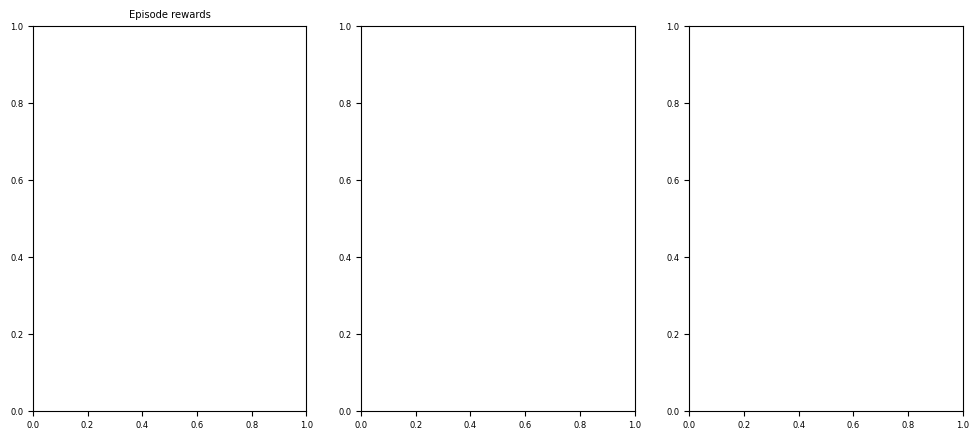

In [ ]:
rolling_length = 500
fig, axs = plt.subplots(ncols=3, figsize=(12, 5))
axs[0].set_title("Episode rewards")
# compute and assign a rolling average of the data to provide a smoother graph
reward_moving_average = (
    np.convolve(
        np.array(env.return_queue).flatten(), np.ones(rolling_length), mode="valid"
    )
    / rolling_length
)
axs[0].plot(range(len(reward_moving_average)), reward_moving_average)
axs[1].set_title("Episode lengths")
length_moving_average = (
    np.convolve(
        np.array(env.length_queue).flatten(), np.ones(rolling_length), mode="same"
    )
    / rolling_length
)
axs[1].plot(range(len(length_moving_average)), length_moving_average)
axs[2].set_title("Training Error")
training_error_moving_average = (
    np.convolve(np.array(snake_agent.training_error), np.ones(rolling_length), mode="same")
    / rolling_length
)
axs[2].plot(range(len(training_error_moving_average)), training_error_moving_average)
plt.tight_layout()
plt.show()